This notebook contains code to detect significant variation in light curves using two simple statistics: reduced Chi-square and variability index.


In [3]:

import glob
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.time import Time
#from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from datetime import datetime
from pylab import rcParams
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import hdbscan
from sklearn.decomposition import PCA
import seaborn as sns
import umap
import os
import matplotlib.pyplot as plt
from astropy.table import QTable
import numpy as np
from matplotlib import colors
from matplotlib.cm import ScalarMappable

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
#Data here and sort: In our case our lightcurves are an ecsv format 
#The data contains 5 simuated variable sources (Source 25, 28, 102, 464, 700, 1086)
def natural_sort(l):

    """
    https://stackoverflow.com/questions/4836710/is-there-a-built-in-function-for-string-natural-sort
    """

    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

File_list_unsorted = glob.glob("/home/gcilitshana/Project/New/madroon-1/obs-u0-qc2/lc1_fakeT5_last/src-chunk0*/src0*")


In [7]:
def chi_square(list_LC):
    """
    Calculate chi-square values for each light curve.

    Parameters:
        list_LC (list): List of paths to light curve files.

    Returns:
        tuple: A tuple containing chi-square values, median values, variability index,
               dataframes for flux and error, maximum flux values, light curve IDs,
               timestamps, flux, and error arrays.
    """
    # Initialize lists to store data
    timestamps = []
    flux = []
    error = []
    ID = []

    # Read data from light curve files
    for lc_path in sorted(list_LC):
        file_name = os.path.basename(lc_path)
        first_9_characters = file_name[:9]
        open_LC = Table.read(lc_path)
        x = open_LC['flux']
        t = open_LC['time']
        e = open_LC['flux_err']
        t_mjd = Time(t, format='isot', scale='utc').mjd
        timestamps.append(t_mjd)
        flux.append(x)
        error.append(e)
        ID.append(first_9_characters)

    # Convert lists to numpy arrays
    timestamps = np.array(timestamps)
    flux = np.array(flux)
    error = np.array(error)
    ID = np.array(ID)

    # Create dataframes and remove rows with all zeros
    df_flux = pd.DataFrame(flux)
    df_flux = df_flux.loc[:, (df_flux != 0).any(axis=0)]
    df_error = pd.DataFrame(error)
    df_error = df_error.loc[:, (df_error != 0).any(axis=0)]

    # Calculate weights
    weights = [(1 / (df_error.loc[i] ** 2)) for i in range(len(flux))]
    weights = np.array(weights)

    # Calculate the weighted mean
    weighted_mean = [np.sum(df_flux.loc[i] * weights[i]) / np.sum(weights[i]) for i in range(len(flux))]
    weighted_mean = np.array(weighted_mean)

    # Calculate chi-square for each light curve and median
    chi_sq = [(1 / (len(flux[i]) - 1)) * np.sum(((df_flux.loc[i] - weighted_mean[i]) ** 2) / (df_error.loc[i] ** 2))
              for i in range(len(flux))]
    median_flux = [np.median(df_flux.loc[i]) for i in range(len(flux))]

    # Calculate the variability index of each light curve
    V_index = [np.std(df_flux.loc[i]) / np.mean(df_flux.loc[i]) for i in range(len(flux))]
    max_flux = [np.max(df_flux.loc[i]) for i in range(len(flux))]

    return np.array(chi_sq), np.array(median_flux), np.array(V_index), df_flux, df_error, \
           np.array(max_flux), ID, timestamps, flux, error


In [11]:
chi,mediann,V_index,df,df2,maxi,ID, timestamp, flux, error= chi_square(File_list_unsorted)

To begin, let's look into the Reduced Chi-Square. We'll start by plotting the reduced chi-square against both the maximum and median flux values.

1. Initially, we need to establish a threshold to classify light curves as significantly variable or not.

2. Next, we'll plot the reduced chi-square against both the maximum and median flux, alongside the established threshold. Light curves with values above this threshold will be deemed variable.

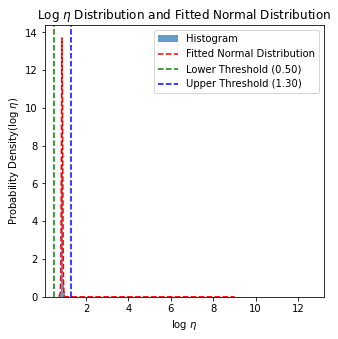

Mean log h: 0.87
Standard Deviation log h: 0.03
Lower Threshold: 0.50
Upper Threshold: 1.30


In [16]:
# Calculating the threshold

from scipy.optimize import curve_fit
from astropy.stats import bayesian_blocks

def fit_log_h_distribution(log_h_data, lower_threshold=None, upper_threshold=None):
    # Create a histogram with Bayesian Blocks binning
    bins = bayesian_blocks(log_h_data)
    hist, bin_edges = np.histogram(log_h_data, bins=bins, density=True)

    # Find bin centers
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Define a normal distribution function to fit
    def normal_distribution(x, mean, std_dev):
        return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

    # Initial guesses for mean and standard deviation
    initial_guess = (np.mean(log_h_data), np.std(log_h_data))

    # Fit the histogram data to the normal distribution function
    params, covariance = curve_fit(normal_distribution, bin_centers, hist, p0=initial_guess)

    # Extract the best-fit parameters
    mean_log_h, std_dev_log_h = params

    # Create a plot of the histogram and the fitted normal distribution
    plt.figure(figsize=(5,5))
    plt.hist(log_h_data, bins=bins, density=True, alpha=0.7, label='Histogram')
    plt.plot(bin_centers, normal_distribution(bin_centers, *params), 'r--', label='Fitted Normal Distribution')

    # Add lower threshold line if specified
    if lower_threshold is not None:
        plt.axvline(x=lower_threshold, color='g', linestyle='--', label=f'Lower Threshold ({lower_threshold:.2f})')

    # Add upper threshold line if specified
    if upper_threshold is not None:
        plt.axvline(x=upper_threshold, color='b', linestyle='--', label=f'Upper Threshold ({upper_threshold:.2f})')

    plt.xlabel('log $\\eta$')
    plt.ylabel('Probability Density(log $\\eta$)')
    plt.legend()
    plt.title('Log $\\eta$ Distribution and Fitted Normal Distribution')

    # Show the plot
    plt.show()

    return mean_log_h, std_dev_log_h

# Example usage:
if __name__ == "__main__":
    # Replace this with your log h data
    log_h_data =chi

    # Specify lower and upper thresholds (e.g., 4 sigmas from the mean)
    lower_threshold = np.mean(log_h_data) - 1 * np.std(log_h_data)
    upper_threshold = np.mean(log_h_data) + 1 * np.std(log_h_data)

    mean_log_h, std_dev_log_h = fit_log_h_distribution(log_h_data, lower_threshold, upper_threshold)
    print(f"Mean log h: {mean_log_h:.2f}")
    print(f"Standard Deviation log h: {std_dev_log_h:.2f}")
    print(f"Lower Threshold: {lower_threshold:.2f}")
    print(f"Upper Threshold: {upper_threshold:.2f}")

/tmp/ipykernel_193188/320617622.py:8: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/320617622.py:19: RuntimeWarning:

invalid value encountered in log



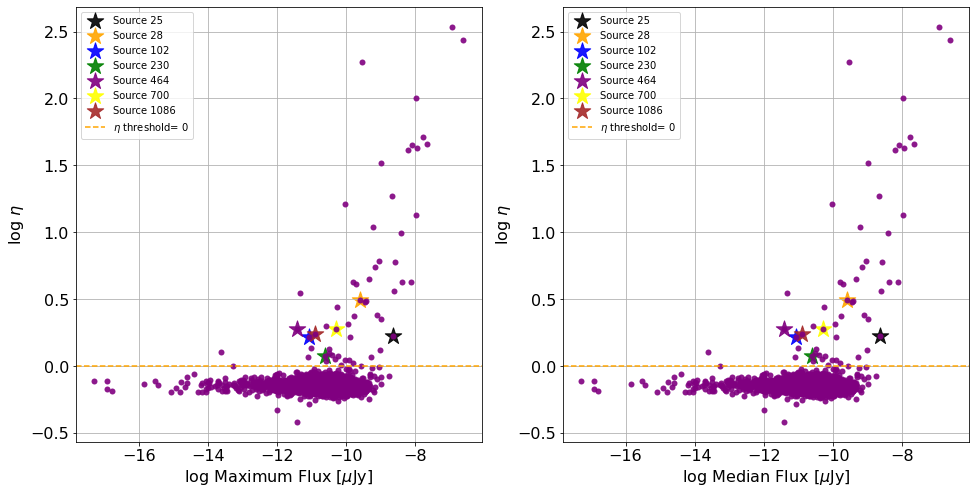

In [22]:
# Plotting the reduced chi square vs maximum flux and median flux
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
# Define the indices you want to mark with stars (simulated variable sources)
indices_to_mark = [25,28,102, 230, 464, 700, 1086]
star_colors = ['black','orange','blue', 'green', 'purple', 'yellow','brown']

ax = axes[0]
ax.plot(np.log(maxi), np.log(chi), 'o', c='purple', alpha=0.9, markeredgecolor='none')
for index, color in zip(indices_to_mark, star_colors):
    ax.scatter(np.log(maxi[index]), np.log(chi[index]), c=color, alpha=0.9, marker='*', s=300, label=f'Source {index}')
ax.axhline(y=0, color='orange', linestyle='--', label='$\\eta$ threshold= 0')
ax.set_xlabel('log Maximum Flux [$\\mu$Jy]', fontsize=16)
ax.set_ylabel('log $\\eta$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
ax.grid(True)

ax = axes[1]
ax.plot(np.log(mediann), np.log(chi), 'o', c='purple', alpha=0.9, markeredgecolor='none')
for index, color in zip(indices_to_mark, star_colors):
    ax.scatter(np.log(mediann[index]), np.log(chi[index]), c=color, alpha=0.9, marker='*', s=300, label=f'Source {index}')
ax.axhline(y=0, color='orange', linestyle='--', label='$\\eta$ threshold= 0')
ax.set_xlabel('log Median Flux [$\\mu$Jy]', fontsize=16)
ax.set_ylabel('log $\\eta$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
ax.grid(True)


Now, we calculate the variability index by utilising a PYBDSF catalog. We extract the flux of each source along with its standard deviation. The variability index is used to quantify the variability of a LC.

In [23]:
# Assuming you have a file named "data.ecsv"
filenames = File_list_unsorted
filename = natural_sort(filenames)
flux_v = []
std_v = []
for filename in File_list_unsorted:
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            if line_number == 35:
                # Extract flux values at columns 11 to 20 (inclusive)
                characters_at_35_11_to_20 = line[10:20]
                # Check if the string is in scientific notation format
                if 'e' in characters_at_35_11_to_20:
                    # Append 'e0' to represent the missing exponent
                    characters_at_35_11_to_20 += '0'
                flux_v.append(float(characters_at_35_11_to_20))

            elif line_number == 66:
                # Extract standard deviation values at columns 13 to 20 (inclusive)
                characters_at_66_13_to_20 = line[12:20]
                std_v.append(float(characters_at_66_13_to_20))

# Convert lists to NumPy arrays
flux_v = np.array(flux_v)
std_v = np.array(std_v)

# Compute M_index
M_index = std_v / flux_v
print("Flux values:", flux_v)
print("Standard deviation values:", std_v)
print("M_index:", M_index)

Flux values: [0.00011286 0.00011363 0.00011272 ... 0.00016394 0.00016123 0.0001653 ]
Standard deviation values: [0.000163 0.000161 0.000151 ... 0.000158 0.000156 0.000158]
M_index: [1.44426723 1.41687935 1.33960256 ... 0.96376723 0.96756187 0.95583787]


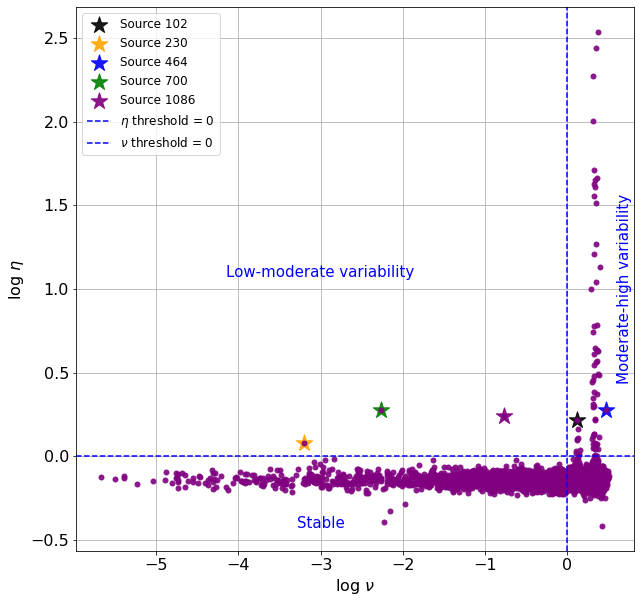

In [27]:
#Plot the variability index against the reduced chi-sqare to estabkisg=h a threshold

fig, ax = plt.subplots(figsize=(10, 10))
# Initialize lists to store indices
indices_eta_pos_nu_pos = []
indices_eta_neg_nu_neg = []
indices_eta_neg_nu_pos = []
indices_eta_pos_nu_neg = []
# Plot the data points
ax.plot(np.log(M_index), np.log(chi), 'o', c='purple', alpha=0.9, markeredgecolor='none')
for index, color in zip(indices_to_mark, star_colors):
    ax.scatter(np.log(M_index[index]), np.log(chi[index]), c=color, alpha=0.9, marker='*', s=300, label=f'Source {index}')

# Plot the horizontal line at y = 0
ax.text(-3, -0.4, 'Stable', fontsize=15, color='blue', ha='center', va='center')
plt.text(-3, 1.1, 'Low-moderate variability', fontsize=15, color='blue', ha='center', va='center')
plt.text(0.7, 1, 'Moderate-high variability', fontsize=15, color='blue', ha='center', va='center', rotation=90)
ax.axhline(y=0, color='blue', linestyle='--', label='$\\eta$ threshold = 0')

# Plot the vertical line at x = 0
ax.axvline(x=0, color='blue', linestyle='--', label='$\\nu$ threshold = 0')

# Set labels and legend
ax.set_xlabel('log $\\nu$', fontsize=16)
ax.set_ylabel('log $\\eta$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12)

# Grid lines
ax.grid(True)

# Identify indices based on thresholds
for i in range(len(np.log(chi))):
    if np.log(chi[i]) > 0 and np.log(M_index[i]) > 0:
        indices_eta_pos_nu_pos.append(i)
    elif np.log(chi[i]) < 0 and np.log(M_index[i]) < 0:
        indices_eta_neg_nu_neg.append(i)

    elif np.log(chi[i]) < 0 and np.log(M_index[i]) > 0:
        indices_eta_neg_nu_pos.append(i)

    elif np.log(chi[i]) > 0 and np.log(M_index[i]) < 0:
        indices_eta_pos_nu_neg.append(i)

plt.show()


For completeness, we plot the variability index against both the maximum flux and the median flux. Different classifications are represented with distinct colors.

/tmp/ipykernel_193188/1267511988.py:27: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/1267511988.py:31: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/1267511988.py:34: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/1267511988.py:37: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/1267511988.py:40: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_193188/1267511988.py:43: RuntimeWarning:

invalid value encountered in log



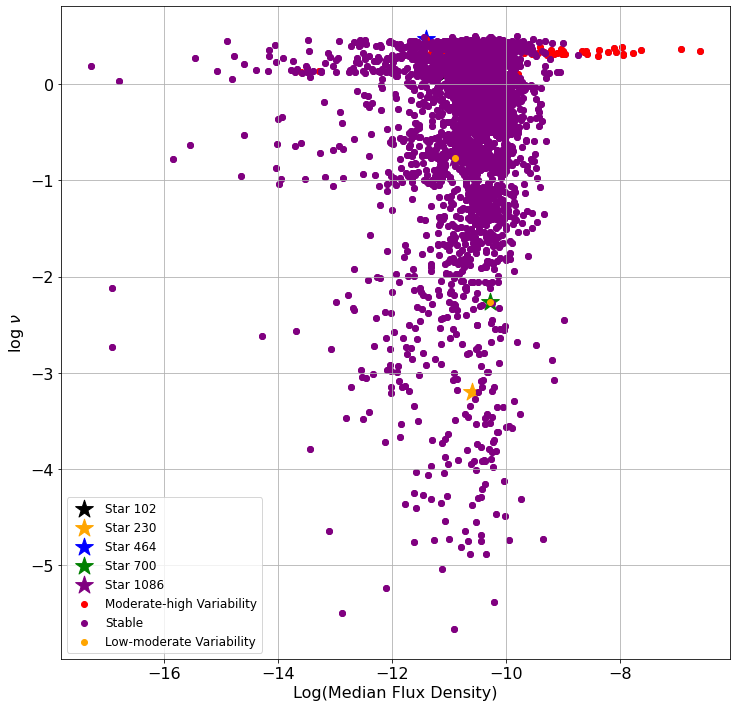

In [20]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# Define the indices you want to mark with stars
indices_to_mark = [102, 230, 464, 700, 1086]
star_colors = ['black', 'orange', 'blue', 'green', 'purple']

indices_eta_pos_nu_pos = []
indices_eta_neg_nu_neg = []
indices_eta_neg_nu_pos = []
indices_eta_pos_nu_neg = []

# Identify indices based on thresholds
for i in range(len(np.log(chi))):
    if np.log(chi[i]) > 0 and np.log(M_index[i]) > 0:
        indices_eta_pos_nu_pos.append(i)
    elif np.log(chi[i]) < 0 and np.log(M_index[i]) < 0:
        indices_eta_neg_nu_neg.append(i)
    elif np.log(chi[i]) < 0 and np.log(M_index[i]) > 0:
        indices_eta_neg_nu_pos.append(i)
    elif np.log(chi[i]) > 0 and np.log(M_index[i]) < 0:
        indices_eta_pos_nu_neg.append(i)
maxi =mediann
# Plot data points
ax.scatter(np.log(maxi), np.log(M_index), c='purple', alpha=0.9, marker='o')

# Plot stars at indices_to_mark
for index, color in zip(indices_to_mark, star_colors):
    ax.scatter(np.log(maxi)[index], np.log(M_index)[index], c=color, marker='*', s=350, label=f'Star {index}')

# Plot indices_eta_pos_nu_pos in one color
ax.scatter(np.log(maxi)[indices_eta_pos_nu_pos], np.log(M_index)[indices_eta_pos_nu_pos], color='red', label='Moderate-high Variability')

# Plot indices_eta_neg_nu_neg in another color
ax.scatter(np.log(maxi)[indices_eta_neg_nu_neg], np.log(M_index)[indices_eta_neg_nu_neg], color='purple', label='Stable')

# Plot indices_eta_neg_nu_pos in another color
ax.scatter(np.log(maxi)[indices_eta_neg_nu_pos], np.log(M_index)[indices_eta_neg_nu_pos], color='purple')

# Plot indices_eta_neg_nu_neg in another color
ax.scatter(np.log(maxi)[indices_eta_pos_nu_neg], np.log(M_index)[indices_eta_pos_nu_neg], color='orange', label='Low-moderate Variability')


# Set labels and legend
ax.set_xlabel('Log(Median Flux Density)', fontsize=16)
ax.set_ylabel('log $\\nu$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12)

# Grid lines
ax.grid(True)

plt.show()
